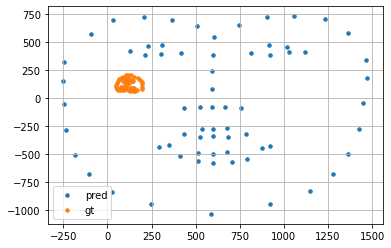

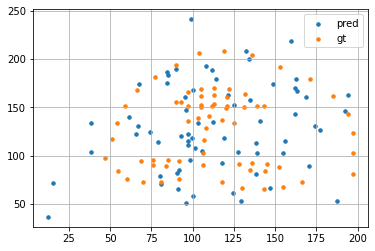

In [ ]:
from statistics import variance
from tkinter import N
# from winreg import DeleteValue
import h5py
# import dlib
import numpy as np
from math import radians, cos, sin, tan
import matplotlib.pyplot as plt
import cv2
import torch
import torch.nn as nn
import torch.optim as optim
from supplemental_code.supplemental_code import *
import os

os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

def load_weights(bfm, model, dim, M):
    id = np.asarray(bfm[model+"/model/mean"] , dtype=np.float32)
    id = np.reshape(id, (-1, 3))
    basis =  np.asarray(bfm[model+"/model/pcaBasis"] , dtype=np.float32)
    basis = np.reshape(basis, (-1, 3, dim))[:, :, :M]
    variance = np.asarray(bfm[model+"/model/pcaVariance"] , dtype=np.float32)[:M]
    return id, basis, variance

class LatentNet(nn.Module):
    def __init__(self, rotation, translation, alpha, delta):
        super(LatentNet, self).__init__()
        self.rotation = torch.tensor(rotation, dtype=torch.float32)
        self.rotation = nn.Parameter(self.rotation, requires_grad = True)

        self.translation = torch.tensor(translation, dtype=torch.float32)
        self.translation = nn.Parameter(self.translation, requires_grad = True)

        self.alpha = torch.tensor(alpha, dtype=torch.float32)
        self.alpha = nn.Parameter(self.alpha, requires_grad = True)

        self.delta = torch.tensor(delta, dtype=torch.float32)
        self.delta = nn.Parameter(self.delta, requires_grad = True)

    def forward(self):
        G = morphable_model_torch(self.alpha, self.delta)
        rot_mat = self.construct_transform()
        G = G[indices_model,:]
        G = (rot_mat @ G.T).T + self.translation
        _, image_2d = pinhole_camera_model_torch(rot_mat, self.translation, G)
        return image_2d

    def construct_transform(self):
            R_x = torch.zeros((3, 3))
            R_x[0, 0] = 1
            R_x[1, 1] = torch.cos(self.rotation[0])
            R_x[1, 2] = -torch.sin(self.rotation[0])
            R_x[2, 1] = torch.sin(self.rotation[0])
            R_x[2, 2] = torch.cos(self.rotation[0])

            R_y = torch.zeros((3, 3))
            R_y[1][1] = 1
            R_y[0][0] = torch.cos(self.rotation[1])
            R_y[0][2] = torch.sin(self.rotation[1])
            R_y[2][0] = -torch.sin(self.rotation[1])
            R_y[2][2] = torch.cos(self.rotation[1])

            R_z = torch.zeros((3, 3))
            R_z[2][2] = 1
            R_z[0][0] = torch.cos(self.rotation[2])
            R_z[0][1] = -torch.sin(self.rotation[2])
            R_z[1][0] = torch.sin(self.rotation[2])
            R_z[1][1] = torch.cos(self.rotation[2])

            return R_z @ R_y @ R_x

def morphable_model_torch(alpha, delta):
    # G calculation
    id_var = mu_id_m + torch.matmul(basis_id_m, alpha * torch.sqrt(variance_id_m))
    exp_var = mu_exp_m + torch.matmul(basis_exp_m, delta * torch.sqrt(variance_exp_m))
    G = id_var + exp_var
    return G

def pinhole_camera_model_torch(rot_mat, translation, G):
    # set new coordinates
    n = 12
    f = 108
    fov = 0.5
    aspect_ratio = 1
    t = tan(fov/2) * n
    b = -t
    r = t * aspect_ratio
    l = b
    # calculate transformation matrix T
    # matT = matrixT_torch(rotation, translation)
     # calculate viewpoint matrix
    Vp = torch.tensor([[(r-l)/2, 0, 0, (r+l)/2],
                    [0, (t-b)/2, 0, (t+b)/2],
                    [0, 0, 0.5, 0.5],
                    [0, 0, 0, 1]])
    # calculate projection matrix
    P = torch.tensor([[(2*n)/(r-l), 0, (r+l)/(r-l), 0],
                    [0, (2*n)/(t-b), (t+b)/(t-b), 0],
                    [0, 0, -(f+n)/(f-n), -(2*f*n)/(f-n)],
                    [0, 0, -1, 0]])

#     G_new = (rot_mat @ G.T).T + translation
    G_new = G
    # add ones to 3D points
    # G_4D = torch.cat((G_new, torch.ones(G_new.shape[0], 1)), 1)
    G_4D = torch.cat((G_new, torch.ones(G_new.shape[0], 1)), 1)
    PI = torch.matmul(Vp, P)
    image_2d = torch.matmul(G_4D, PI)
    return G_new, image_2d[:,:2]

def load_landmark(image_2d):
    f = open('supplemental_code/Landmarks68_model2017-1_face12_nomouth.anl','r')
    lines = f.readlines()
    # put indices to a list
    lines = [int(line) for line in lines]
    # find the mappings
    pred = image_2d.T[:, :2][lines]
    # return the prediction and the homogeneous coordinate
    return pred, image_2d.T[lines][:, 3]

def visualize_landmark(pred, name):
    plt.scatter(pred[:,0], pred[:,1], s = 12)
    plt.grid(True)
    plt.show()
    # plt.savefig(name)

def comp_plot(pred, gt):
    plt.scatter(pred[:,0], pred[:,1], s = 12, label='pred')
    plt.scatter(gt[:,0], gt[:,1], s = 12, label='gt')
    plt.grid(True)
    plt.legend()
    plt.show()

def loss_estimation(model, gt_landmark, la, ld):
    uv = model()

    L_lan = torch.mean(torch.linalg.norm((uv - gt_landmark)) ** 2)
    L_reg = la * torch.sum(torch.pow(model.alpha, 2)) + ld * torch.sum(torch.pow(model.delta, 2))
    L_fit = L_lan + L_reg

    # comp_plot(uv.detach().numpy(), gt_landmark.detach().numpy())
    return L_fit, uv

def normalize_tensor(inp):

    x_translate = np.min(inp[:,0]) + (np.max(inp[:,0]) - np.min(inp[:,0]))/2
    y_translate = np.min(inp[:,1]) + (np.max(inp[:,1]) - np.min(inp[:,1]))/2
    inp = inp - np.array([x_translate, y_translate])
    # inp /= inp.amax(0)
    # inp -= inp.mean()
    return inp

def train(lr, epochs, seed, rotation, translation, alpha, delta, la, ld):
    # Set the random seeds for reproducibility
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():  # GPU operation have separate seed
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.determinstic = True
        torch.backends.cudnn.benchmark = False
    # Set default device
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    model = LatentNet(rotation, translation, alpha, delta)
    optimizer = optim.Adam(model.parameters(), lr = lr)
    model.to(device)

    img = cv2.imread('cropped_fg.png')
    gt_landmark = detect_landmark(img)
    # gt_landmark = normalize_tensor(gt_landmark)
    gt_landmark = torch.tensor(gt_landmark)

    # plt.scatter(*gt_landmark.T)
    # plt.show()

    losses = []
    model.train()
    prev_loss = 1000000000000
    prev_model = model
    best_model = model
    for epoch in range(epochs):
        optimizer.zero_grad()
        loss, uv = loss_estimation(model, gt_landmark, la, ld)
        losses.append(loss.item())
        loss.backward()
        optimizer.step()

        if epoch % 1000 == 0:
            comp_plot(uv.detach().numpy(), gt_landmark)

        with torch.no_grad():
            train_loss = torch.mean(torch.Tensor(losses))
        if (train_loss > prev_loss + 0.001):
            print('Training stopped due to early stopping')
            best_model = prev_model
            break
        elif train_loss < prev_loss:
            best_model = prev_model
        else:
            prev_loss = train_loss
            prev_model = model

        # print(f"[{'train'}] Epoch: {epoch+1} / {epochs} Loss: {train_loss}")
        # print("-------------------------------------------------------------------------------------")

    return losses, best_model


bfm = h5py.File("model2017-1_face12_nomouth.h5", "r")

# Select facial identity from BFM
mu_id, basis_id, variance_id = load_weights(bfm, "shape", 199, 30)
# Select expression from BFM
mu_exp, basis_exp, variance_exp = load_weights(bfm, "expression", 100, 20)

mu_id_m, basis_id_m, variance_id_m = torch.Tensor(mu_id), torch.Tensor(basis_id), torch.Tensor(variance_id)
mu_exp_m, basis_exp_m, variance_exp_m = torch.Tensor(mu_exp), torch.Tensor(basis_exp), torch.Tensor(variance_exp)

# Triangle topology and triangle
triangle = np.asarray(bfm["shape/representer/cells"] , dtype=np.float32)
color = np.asarray(bfm["color/model/mean"] , dtype=np.float32)
color = np.reshape(color, (-1, 3))

indices_model = np.loadtxt("supplemental_code/Landmarks68_model2017-1_face12_nomouth.anl")

#--------------------------------------------------------------------#
# part 4.2.1
# Uniform distribution
# alpha = np.random.uniform(-1, 1, 30)
# delta = np.random.uniform(-1, 1, 20)
np.random.seed(42)
alpha = np.random.normal(size=30)
delta = np.random.normal(size=20)

G, triangle, color = morphable_model(bfm, alpha, delta)
# print(G.shape)
# save_obj('3D.obj', G, color, triangle.T)
#--------------------------------------------------------------------#
# part 4.2.2.a
rotation = [0, np.pi, 0]
translation = [50, 0, -500]
# Trans_G, image_2d = pinhole_camera_model(rotation, translation, G)
# save_obj('3D_right_rot.obj', Trans_G.T[:, :3], color, triangle.T)
# print(Trans_G.T[:, 0:3].shape, color.shape, triangle.astype(int).T.shape)
# facee = render(Trans_G.T[:, :3], color, triangle.astype(int).T)
# plt.imshow(facee)
# plt.show()
# # #--------------------------------------------------------------------#
# # # part 4.2.2.b
# uv, homog = load_landmark(image_2d)
# # U,V projection (corresponding 2D pixel coordinate of each 3D point)
# uv_2d = (uv.T / homog).T
# plt.scatter(*uv.T)
# plt.show()
# visualize_landmark(uv_2d, 'landmark.jpg')
# #--------------------------------------------------------------------#
# # part 4.2.3.a
# img = cv2.imread('cropped_bg.jpg')
# gt_landmark = detect_landmark(img)
# for (x, y) in gt_landmark:
#     cv2.circle(img, (x, y), 2, (0, 255, 0), 2)
#     cv2.imwrite('landmark_gt.jpg', img)
# #--------------------------------------------------------------------#

# # part 4.2.3.b
lr = 0.05
epochs = 10000
seed = 42
la = 0.5
ld = 0.5
losses, best_model = train(lr, epochs, seed, rotation, translation, alpha, delta, la, ld)

# # plt.plot(losses)
# # plt.xlabel('Epoch')
# # plt.ylabel('Loss')
# # plt.show()
# # plt.savefig('loss.png')

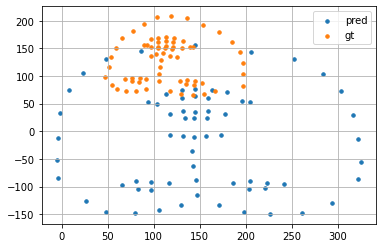

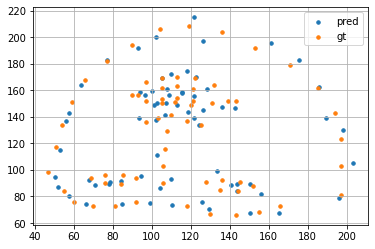

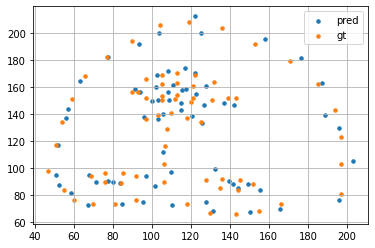

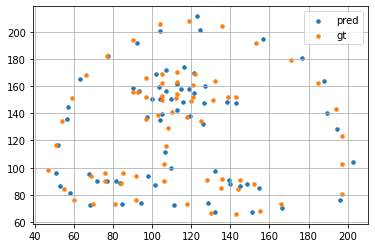

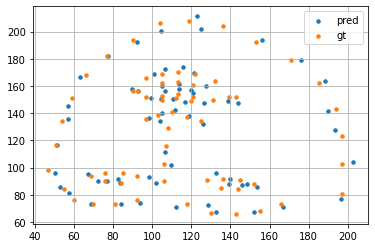

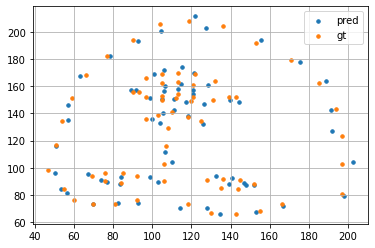

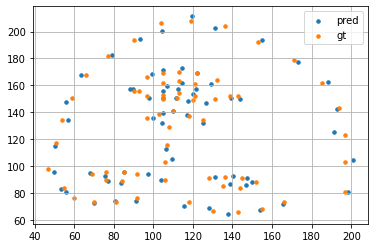

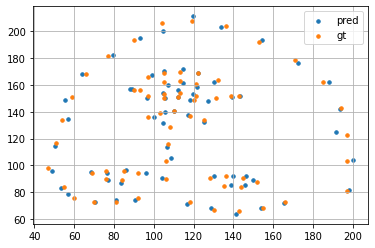

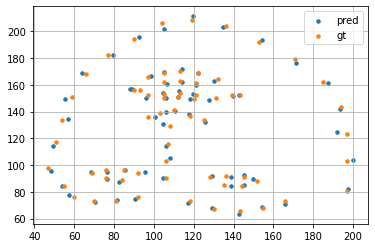

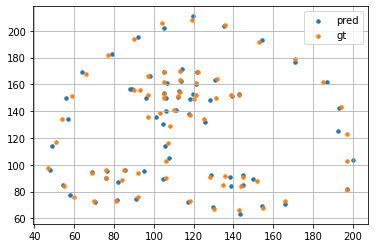

In [149]:
from statistics import variance
from tkinter import N
# from winreg import DeleteValue
import h5py
# import dlib
import numpy as np
from math import radians, cos, sin, tan
import matplotlib.pyplot as plt
import cv2
import torch
import torch.nn as nn
import torch.optim as optim
from supplemental_code.supplemental_code import *
import os

os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

def load_weights(bfm, model, dim, M):
    id = np.asarray(bfm[model+"/model/mean"] , dtype=np.float32)
    id = np.reshape(id, (-1, 3))
    basis =  np.asarray(bfm[model+"/model/pcaBasis"] , dtype=np.float32)
    basis = np.reshape(basis, (-1, 3, dim))[:, :, :M]
    variance = np.asarray(bfm[model+"/model/pcaVariance"] , dtype=np.float32)[:M]
    return id, basis, variance

class LatentNet(nn.Module):
    def __init__(self, rotation, translation, alpha, delta):
        super(LatentNet, self).__init__()
        self.rotation = torch.tensor(rotation, dtype=torch.float32)
        self.rotation = nn.Parameter(self.rotation, requires_grad = True)

        self.translation = torch.tensor(translation, dtype=torch.float32)
        self.translation = nn.Parameter(self.translation, requires_grad = True)

        self.alpha = torch.tensor(alpha, dtype=torch.float32)
        self.alpha = nn.Parameter(self.alpha, requires_grad = True)

        self.delta = torch.tensor(delta, dtype=torch.float32)
        self.delta = nn.Parameter(self.delta, requires_grad = True)

    def forward(self):
        G = morphable_model_torch(self.alpha, self.delta)
        rot_mat = self.construct_transform()
        G = G[indices_model,:]
        G = (rot_mat @ G.T).T + self.translation
        _, image_2d = pinhole_camera_model_torch(rot_mat, self.translation, G)
        return image_2d

    def construct_transform(self):
            R_x = torch.zeros((3, 3))
            R_x[0, 0] = 1
            R_x[1, 1] = torch.cos(self.rotation[0])
            R_x[1, 2] = -torch.sin(self.rotation[0])
            R_x[2, 1] = torch.sin(self.rotation[0])
            R_x[2, 2] = torch.cos(self.rotation[0])

            R_y = torch.zeros((3, 3))
            R_y[1][1] = 1
            R_y[0][0] = torch.cos(self.rotation[1])
            R_y[0][2] = torch.sin(self.rotation[1])
            R_y[2][0] = -torch.sin(self.rotation[1])
            R_y[2][2] = torch.cos(self.rotation[1])

            R_z = torch.zeros((3, 3))
            R_z[2][2] = 1
            R_z[0][0] = torch.cos(self.rotation[2])
            R_z[0][1] = -torch.sin(self.rotation[2])
            R_z[1][0] = torch.sin(self.rotation[2])
            R_z[1][1] = torch.cos(self.rotation[2])

            return R_z @ R_y @ R_x

def morphable_model_torch(alpha, delta):
    # G calculation
    id_var = mu_id_m + torch.matmul(basis_id_m, alpha * torch.sqrt(variance_id_m))
    exp_var = mu_exp_m + torch.matmul(basis_exp_m, delta * torch.sqrt(variance_exp_m))
    G = id_var + exp_var
    return G

def pinhole_camera_model_torch(rot_mat, translation, G):
    # set new coordinates
    n = 12
    f = 108
    fov = 0.5
    aspect_ratio = 1
    t = tan(fov/2) * n
    b = -t
    r = t * aspect_ratio
    l = b
    # calculate transformation matrix T
    # matT = matrixT_torch(rotation, translation)
     # calculate viewpoint matrix
    Vp = torch.tensor([[(r-l)/2, 0, 0, (r+l)/2],
                    [0, (t-b)/2, 0, (t+b)/2],
                    [0, 0, 0.5, 0.5],
                    [0, 0, 0, 1]])
    # calculate projection matrix
    P = torch.tensor([[(2*n)/(r-l), 0, (r+l)/(r-l), 0],
                    [0, (2*n)/(t-b), (t+b)/(t-b), 0],
                    [0, 0, -(f+n)/(f-n), -(2*f*n)/(f-n)],
                    [0, 0, -1, 0]])

#     G_new = (rot_mat @ G.T).T + translation
    G_new = G
    # add ones to 3D points
    # G_4D = torch.cat((G_new, torch.ones(G_new.shape[0], 1)), 1)
    G_4D = torch.cat((G_new, torch.ones(G_new.shape[0], 1)), 1)
    PI = torch.matmul(Vp, P)
    image_2d = torch.matmul(G_4D, PI)
    return G_new, image_2d[:,:2]

def load_landmark(image_2d):
    f = open('supplemental_code/Landmarks68_model2017-1_face12_nomouth.anl','r')
    lines = f.readlines()
    # put indices to a list
    lines = [int(line) for line in lines]
    # find the mappings
    pred = image_2d.T[:, :2][lines]
    # return the prediction and the homogeneous coordinate
    return pred, image_2d.T[lines][:, 3]

def visualize_landmark(pred, name):
    plt.scatter(pred[:,0], pred[:,1], s = 12)
    plt.grid(True)
    plt.show()
    # plt.savefig(name)

def comp_plot(pred, gt):
    plt.scatter(pred[:,0], pred[:,1], s = 12, label='pred')
    plt.scatter(gt[:,0], gt[:,1], s = 12, label='gt')
    plt.grid(True)
    plt.legend()
    plt.show()

def loss_estimation(model, gt_landmark, la, ld):
    uv = model()

    L_lan = torch.mean(torch.linalg.norm((uv - gt_landmark)) ** 2)
    L_reg = la * torch.sum(torch.pow(model.alpha, 2)) + ld * torch.sum(torch.pow(model.delta, 2))
    L_fit = L_lan + L_reg

    # comp_plot(uv.detach().numpy(), gt_landmark.detach().numpy())
    return L_fit, uv

def normalize_tensor(inp):

    x_translate = np.min(inp[:,0]) + (np.max(inp[:,0]) - np.min(inp[:,0]))/2
    y_translate = np.min(inp[:,1]) + (np.max(inp[:,1]) - np.min(inp[:,1]))/2
    inp = inp - np.array([x_translate, y_translate])
    # inp /= inp.amax(0)
    # inp -= inp.mean()
    return inp

def train(lr, epochs, seed, rotation, translation, alpha, delta, la, ld):
    # Set the random seeds for reproducibility
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():  # GPU operation have separate seed
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.determinstic = True
        torch.backends.cudnn.benchmark = False
    # Set default device
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    model = LatentNet(rotation, translation, alpha, delta)
    optimizer = optim.Adam(model.parameters(), lr = lr)
    model.to(device)

    img = cv2.imread('cropped_fg.png')
    gt_landmark = detect_landmark(img)
    # gt_landmark = normalize_tensor(gt_landmark)
    gt_landmark = torch.tensor(gt_landmark)

    # plt.scatter(*gt_landmark.T)
    # plt.show()

    losses = []
    model.train()
    prev_loss = 1000000000000
    prev_model = model
    best_model = model
    for epoch in range(epochs):
        optimizer.zero_grad()
        loss, uv = loss_estimation(model, gt_landmark, la, ld)
        losses.append(loss.item())
        loss.backward()
        optimizer.step()

        if epoch % 1000 == 0:
            comp_plot(uv.detach().numpy(), gt_landmark)

        with torch.no_grad():
            train_loss = torch.mean(torch.Tensor(losses))
        if (train_loss > prev_loss + 0.001):
            print('Training stopped due to early stopping')
            best_model = prev_model
            break
        elif train_loss < prev_loss:
            best_model = prev_model
        else:
            prev_loss = train_loss
            prev_model = model

        # print(f"[{'train'}] Epoch: {epoch+1} / {epochs} Loss: {train_loss}")
        # print("-------------------------------------------------------------------------------------")

    return losses, best_model


bfm = h5py.File("model2017-1_face12_nomouth.h5", "r")

# Select facial identity from BFM
mu_id, basis_id, variance_id = load_weights(bfm, "shape", 199, 30)
# Select expression from BFM
mu_exp, basis_exp, variance_exp = load_weights(bfm, "expression", 100, 20)

mu_id_m, basis_id_m, variance_id_m = torch.Tensor(mu_id), torch.Tensor(basis_id), torch.Tensor(variance_id)
mu_exp_m, basis_exp_m, variance_exp_m = torch.Tensor(mu_exp), torch.Tensor(basis_exp), torch.Tensor(variance_exp)

# Triangle topology and triangle
triangle = np.asarray(bfm["shape/representer/cells"] , dtype=np.float32)
color = np.asarray(bfm["color/model/mean"] , dtype=np.float32)
color = np.reshape(color, (-1, 3))

indices_model = np.loadtxt("supplemental_code/Landmarks68_model2017-1_face12_nomouth.anl")

#--------------------------------------------------------------------#
# part 4.2.1
# Uniform distribution
# alpha = np.random.uniform(-1, 1, 30)
# delta = np.random.uniform(-1, 1, 20)
np.random.seed(42)
alpha = np.random.normal(size=30)
delta = np.random.normal(size=20)

G, triangle, color = morphable_model(bfm, alpha, delta)
# print(G.shape)
# save_obj('3D.obj', G, color, triangle.T)
#--------------------------------------------------------------------#
# part 4.2.2.a
rotation = [0, np.pi, 0]
translation = [50, 0, -500]
# Trans_G, image_2d = pinhole_camera_model(rotation, translation, G)
# save_obj('3D_right_rot.obj', Trans_G.T[:, :3], color, triangle.T)
# print(Trans_G.T[:, 0:3].shape, color.shape, triangle.astype(int).T.shape)
# facee = render(Trans_G.T[:, :3], color, triangle.astype(int).T)
# plt.imshow(facee)
# plt.show()
# # #--------------------------------------------------------------------#
# # # part 4.2.2.b
# uv, homog = load_landmark(image_2d)
# # U,V projection (corresponding 2D pixel coordinate of each 3D point)
# uv_2d = (uv.T / homog).T
# plt.scatter(*uv.T)
# plt.show()
# visualize_landmark(uv_2d, 'landmark.jpg')
# #--------------------------------------------------------------------#
# # part 4.2.3.a
# img = cv2.imread('cropped_bg.jpg')
# gt_landmark = detect_landmark(img)
# for (x, y) in gt_landmark:
#     cv2.circle(img, (x, y), 2, (0, 255, 0), 2)
#     cv2.imwrite('landmark_gt.jpg', img)
# #--------------------------------------------------------------------#

# # part 4.2.3.b
lr = 0.05
epochs = 10000
seed = 42
la = 0.5
ld = 0.5
losses, best_model = train(lr, epochs, seed, rotation, translation, alpha, delta, la, ld)

# # plt.plot(losses)
# # plt.xlabel('Epoch')
# # plt.ylabel('Loss')
# # plt.show()
# # plt.savefig('loss.png')

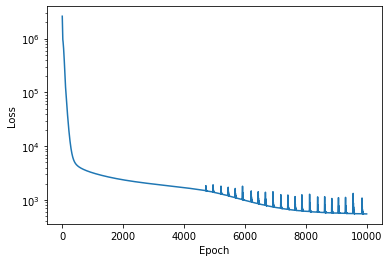

In [150]:
plt.plot(losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.yscale('log')
plt.show()
# plt.savefig('loss.png')

In [151]:
G = morphable_model_torch(best_model.alpha, best_model.delta)
rot_mat = best_model.construct_transform()
G = (rot_mat @ G.T).T + best_model.translation
image_2d = convertTo2D(G).clip(777)

In [152]:
uvd = image_2d.detach().numpy()

In [153]:
uvds = np.hstack((uvd, np.zeros((uvd.shape[0], 1)))) -1

In [154]:
uvdint = uvd.astype(int)
color2 = []
img = cv2.imread('cropped_bg.jpg')
for point in uvdint:
    color2.append(img[point[0], point[1]] / 255)
color2 = np.asarray(color2)

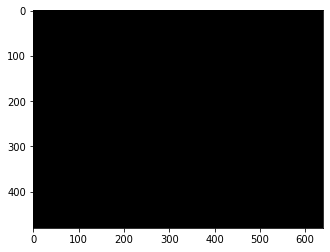

In [155]:
facee = render(G.detach().numpy(), color2, triangle.astype(int).T).astype(int)
plt.imshow(facee)
plt.show()
save_obj("textured_face.obj", G.detach().numpy(), color2, triangle.astype(int).T)